In [1]:
%matplotlib inline
import sys 
sys.path.append('../../../')
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import gpflow, gpitch
reload(gpitch)
from gpitch.amtgp import logistic

In [2]:
gpitch.amtgp.init_settings()
plt.rcParams['figure.figsize'] = (16, 3)  # set plot size

In [3]:
np.random.seed(2)
Nc = 3  # number of partials
var = np.random.rand(Nc)  # variances
leng = 10*np.random.rand(Nc)  # lengthscales
freq = 2000*np.random.rand()*np.asarray(range(1, Nc+ 1))  # frequencies
kern_com = gpitch.kernels.MaternSpecMix(input_dim=1, lengthscales=leng, variances=var, frequencies=freq)
kern_act = gpflow.kernels.Matern32(input_dim=1, lengthscales=0.005, variance=10.)

In [4]:
kern_com

Name,values,prior,constraint
unnamed.frequency_1,[ 372.52042276],None,+ve
unnamed.frequency_2,[ 745.04084551],None,+ve
unnamed.frequency_3,[ 1117.56126827],None,+ve
unnamed.lengthscale_1,[ 3.02332573],None,+ve
unnamed.lengthscale_2,[ 1.46755891],None,+ve
unnamed.lengthscale_3,[ 0.92338595],None,+ve
unnamed.variance_1,[ 0.417022],None,+ve
unnamed.variance_2,[ 0.72032449],None,+ve
unnamed.variance_3,[ 0.00011437],None,+ve


In [5]:
kern_act

Name,values,prior,constraint
unnamed.lengthscales,[ 0.005],None,+ve
unnamed.variance,[ 10.],None,+ve


In [6]:
N, fs = 400, 16e3
x = np.linspace(0., (N-1.)/fs, N).reshape(-1, 1)
Kcom = kern_com.compute_K_symm(x)
Kact = kern_act.compute_K_symm(x)

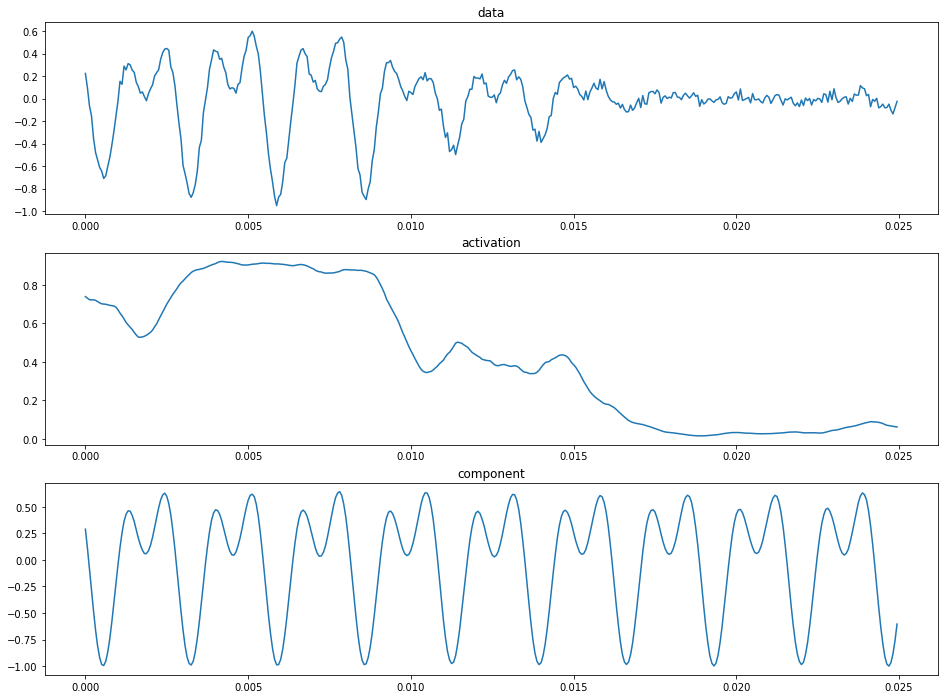

In [7]:
noise_var = 1e-3
com = np.random.multivariate_normal(np.zeros((N)), Kcom, 1).reshape(-1, 1)
com /= np.max(np.abs(com))
g = np.random.multivariate_normal(np.zeros((N)), Kact, 1).reshape(-1, 1)
act = logistic(g)
y = act*com + np.sqrt(noise_var)*np.random.randn(N,1)

plt.figure(figsize=(16, 12))
plt.subplot(3,1,1), plt.title('data')
plt.plot(x, y)
plt.subplot(3,1,2), plt.title('activation')
plt.plot(x, act)
plt.subplot(3,1,3), plt.title('component')
plt.plot(x, com)

In [ ]:
ws, dec = N//1, 10  # samples per window, decimation factor
m = gpitch.modpdet.ModPDet(x=x, y=y, kern_com=kern_com, kern_act=kern_act, ws=ws, dec=dec, whiten=True)
m.model.kern1.fixed = True
m.model.kern2.fixed = False
m.model.likelihood.noise_var.fixed = False

In [ ]:
maxiter, restarts = 500, 10
init_hyper, learnt_hyper, mse = m.optimize_restart(maxiter=maxiter, restarts=restarts)

| len: 0.01478209, 0.00829878 | sig: 3.98268026, 4.01563396 | noise_var: 0.00154436, 0.00107759 |
| len: 0.67449884, 0.01639051 | sig: 8.27203254, 8.34448550 | noise_var: 0.03216481, 0.00117227 |
| len: 0.78020234, 0.00937763 | sig: 2.18678147, 3.93625556 | noise_var: 0.02448806, 0.00110561 |
| len: 0.29231376, 0.00919699 | sig: 2.93897920, 3.95225197 | noise_var: 0.00879387, 0.00110278 |
| len: 0.86997618, 0.01013079 | sig: 1.32282968, 2.80269726 | noise_var: 0.06837103, 0.00113199 |


In [ ]:
m.model.kern2.lengthscales = learnt_hyper[0].mean().copy()
m.model.kern2.variance = learnt_hyper[1].mean().copy()
m.model.likelihood.noise_var = learnt_hyper[2].mean().copy()

In [ ]:
m.model.kern2

In [ ]:
m.model.kern1

In [ ]:
print m.model.likelihood.noise_var

In [ ]:
m.optimize_windowed(disp=1, maxiter=1000)

In [ ]:
m.model.kern1

In [ ]:
m.model.kern2

In [ ]:
print m.model.likelihood.noise_var

In [ ]:
mean_f, var_f = m.model.predict_f(x)
mean_g, var_g = m.model.predict_g(x)
mean_act = logistic(mean_g)

In [ ]:
plt.figure(figsize=(16, 12))
plt.subplot(3,1,1)
plt.plot(x, y, '.k'), plt.title('data')
plt.plot(x, act*com)

plt.subplot(3,1,2)
plt.plot(x, act, '.k'), plt.title('activation')
plt.twinx()
plt.plot(x, mean_act)
plt.plot(x, logistic(mean_g + 2.*np.sqrt(var_g)), '--C0')
plt.plot(x, logistic(mean_g - 2.*np.sqrt(var_g)), '--C0')

plt.subplot(3,1,3)
plt.plot(x, com, '.k'), plt.title('component')
plt.twinx()
plt.plot(x, mean_f)
plt.plot(x, mean_f + 2.*np.sqrt(var_f), '--C0')
plt.plot(x, mean_f - 2.*np.sqrt(var_f), '--C0')